In [86]:
import pandas as pd
final_df_3 = pd.read_csv('../Capstone/final_df_3.csv')

In [87]:
final_df_3.drop(['Unnamed: 0'], axis=1, inplace=True)

In [88]:
final_df_3 = pd.get_dummies(final_df_3, columns=['team_x', 'team_y'])

In [89]:
final_df_3.head(1)

,gsis_id,winner,score_x,score_y,week,day_of_week,defense_ffum_x,defense_frec_x,defense_frec_tds_x,defense_int_x,...,team_y_OAK,team_y_PHI,team_y_PIT,team_y_SD,team_y_SEA,team_y_SF,team_y_STL,team_y_TB,team_y_TEN,team_y_WAS
0,2009091000,1,13,10,1,4,1,1,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


#  Train/Test Split

In [90]:
from sklearn.cross_validation import train_test_split

y = final_df_3['winner']
X = final_df_3.iloc[:, 4:]

In [91]:
X.head(1)

,week,day_of_week,defense_ffum_x,defense_frec_x,defense_frec_tds_x,defense_int_x,defense_int_tds_x,defense_qbhit_x,defense_safe_x,defense_sk_x,...,team_y_OAK,team_y_PHI,team_y_PIT,team_y_SD,team_y_SEA,team_y_SF,team_y_STL,team_y_TB,team_y_TEN,team_y_WAS
0,1,4,1,1,0,1,0,3,0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [92]:
y.value_counts()

1    1057
0     803
Name: winner, dtype: int64

In [93]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [94]:
print y_train.shape
print X_train.shape

(1302,)
(1302, 140)


# Logistic Regression

In [95]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()

In [96]:
model = logreg.fit(X_train,y_train)

In [97]:
model.score(X_train, y_train)

0.96697388632872505

In [98]:
from sklearn import metrics

predicted = model.predict(X_test)
prob = model.predict_proba(X_test)

print metrics.accuracy_score(y_test, predicted)
print metrics.roc_auc_score(y_test, prob[:, 1])

0.935483870968
0.986275650518


In [99]:
print metrics.confusion_matrix(y_test, predicted)
print metrics.classification_report(y_test, predicted)

[[212  20]
 [ 16 310]]
             precision    recall  f1-score   support

          0       0.93      0.91      0.92       232
          1       0.94      0.95      0.95       326

avg / total       0.94      0.94      0.94       558



In [100]:
from sklearn.cross_validation import cross_val_score
scores = cross_val_score(LogisticRegression(), X, y, scoring='accuracy', cv=5)
print scores
print scores.mean()

[ 0.94101877  0.95710456  0.92473118  0.91105121  0.94339623]
0.935460389309


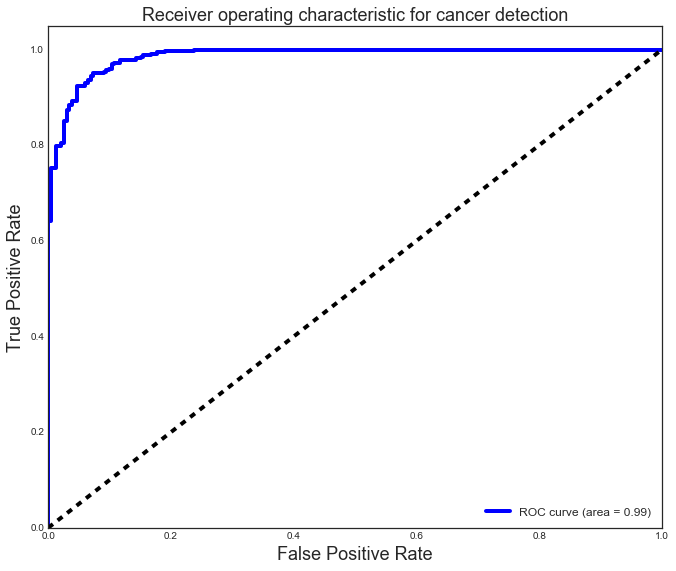

In [101]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
%matplotlib inline

y_score = logreg.decision_function(X_test)

FPR = dict()
TPR = dict()
ROC_AUC = dict()

FPR[1], TPR[1], _ = roc_curve(y_test, y_score)
ROC_AUC[1] = auc(FPR[1], TPR[1])

plt.figure(figsize=[11,9])
plt.plot(FPR[1], TPR[1], label='ROC curve (area = %0.2f)' % ROC_AUC[1], linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Receiver operating characteristic for cancer detection', fontsize=18)
plt.legend(loc="lower right")
plt.show()

In [102]:
logreg_params = {
    'penalty':['l1','l2']
}

In [103]:
logreg_gs = GridSearchCV(LogisticRegression(), logreg_params, cv=5, verbose=1)

In [104]:
logreg_gs.fit(X_train, y_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.4s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'penalty': ['l1', 'l2']}, pre_dispatch='2*n_jobs',
       refit=True, scoring=None, verbose=1)

In [105]:
logreg_best = logreg_gs.best_estimator_
print logreg_best
print logreg_gs.best_params_
print logreg_gs.best_score_

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
{'penalty': 'l2'}
0.927035330261


# Decision Tree

In [106]:
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier()

dtc.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [107]:
cross_val_score(dtc, X_train, y_train, cv=5).mean()

0.81872577803875524

In [108]:
dtc_predicted = dtc.predict(X_test)
dtc_prob = dtc.predict_proba(X_test)

print metrics.accuracy_score(y_test, dtc_predicted)
print metrics.roc_auc_score(y_test, dtc_prob[:, 1])
print metrics.confusion_matrix(y_test, dtc_predicted)
print metrics.classification_report(y_test, dtc_predicted)

0.831541218638
0.824135286651
[[181  51]
 [ 43 283]]
             precision    recall  f1-score   support

          0       0.81      0.78      0.79       232
          1       0.85      0.87      0.86       326

avg / total       0.83      0.83      0.83       558



In [109]:
dtc_params = {
    'max_depth':[None,1,2,3,4],
    'max_features':[None,'log2','sqrt',2,3,4,5],
    'min_samples_split':[2,3,4,5,10,15,20,25]
}

from sklearn.grid_search import GridSearchCV

dtc_gs = GridSearchCV(DecisionTreeClassifier(), dtc_params, cv=5, verbose=1)

In [110]:
dtc_gs.fit(X_train, y_train)

Fitting 5 folds for each of 280 candidates, totalling 1400 fits


[Parallel(n_jobs=1)]: Done  49 tasks       | elapsed:    1.3s
[Parallel(n_jobs=1)]: Done 199 tasks       | elapsed:    2.7s
[Parallel(n_jobs=1)]: Done 449 tasks       | elapsed:    4.9s
[Parallel(n_jobs=1)]: Done 799 tasks       | elapsed:    7.5s
[Parallel(n_jobs=1)]: Done 1249 tasks       | elapsed:   10.7s
[Parallel(n_jobs=1)]: Done 1400 out of 1400 | elapsed:   11.7s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_features': [None, 'log2', 'sqrt', 2, 3, 4, 5], 'min_samples_split': [2, 3, 4, 5, 10, 15, 20, 25], 'max_depth': [None, 1, 2, 3, 4]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=1)

In [111]:
dtc_best = dtc_gs.best_estimator_
print dtc_best
print dtc_gs.best_params_
print dtc_gs.best_score_

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')
{'max_features': None, 'min_samples_split': 2, 'max_depth': 4}
0.837173579109


In [112]:
dtfi = pd.DataFrame({
        'feature':X.columns,
        'importance':dtc_best.feature_importances_
    })

dtfi.sort_values('importance', ascending=False, inplace=True)
dtfi.head()

,feature,importance
70,rushing_att_y,0.447599
37,turnovers_x,0.200986
33,rushing_att_x,0.099932
74,turnovers_y,0.095783
19,passing_incmp_x,0.065426


# Bagging Decision Tree

In [113]:
from sklearn.ensemble import BaggingClassifier
bdtc = BaggingClassifier(DecisionTreeClassifier())

cross_val_score(bdtc, X_train, y_train, cv=5, n_jobs=-1)

array([ 0.86259542,  0.85769231,  0.88076923,  0.86538462,  0.87307692])

In [114]:
params = {'base_estimator__max_depth': [3,5,10,20],
          'max_features': [0.5, 0.7, 1.0],
          'max_samples': [0.5, 0.7, 1.0],
          'n_estimators': [2, 5, 10, 20],
         }

gsbdt = GridSearchCV(bdtc, params, n_jobs=-1, cv=5)

In [115]:
gsbdt.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, ...n_estimators=10, n_jobs=1, oob_score=False,
         random_state=None, verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'max_features': [0.5, 0.7, 1.0], 'max_samples': [0.5, 0.7, 1.0], 'base_estimator__max_depth': [3, 5, 10, 20], 'n_estimators': [2, 5, 10, 20]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [116]:
gsbdt_predicted = gsbdt.predict(X_test)
gsbdt_prob = gsbdt.predict_proba(X_test)

print metrics.accuracy_score(y_test, gsbdt_predicted)
print metrics.roc_auc_score(y_test, gsbdt_prob[:, 1])

0.885304659498
0.953088639729


In [117]:
gsbdt.best_params_

{'base_estimator__max_depth': 5,
 'max_features': 0.5,
 'max_samples': 0.5,
 'n_estimators': 20}

In [177]:
gsbdt.best_score_

0.88709677419354838

# Extra Tree

In [154]:
from sklearn.ensemble import ExtraTreesClassifier
etc = ExtraTreesClassifier()

In [155]:
etc.fit(X_train, y_train)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [156]:
cross_val_score(rfc, X_train, y_train, cv=5)

array([ 0.88549618,  0.83461538,  0.88076923,  0.84615385,  0.88076923])

In [157]:
etc_predicted = etc.predict(X_test)
etc_prob = etc.predict_proba(X_test)

print metrics.accuracy_score(y_test, etc_predicted)
print metrics.roc_auc_score(y_test, etc_prob[:, 1])

0.885304659498
0.943767188492


In [158]:
etc_gs = GridSearchCV(etc, dtc_params, cv=5, verbose=1)

In [161]:
etc_gs.fit(X_train, y_train)

Fitting 5 folds for each of 280 candidates, totalling 1400 fits


[Parallel(n_jobs=1)]: Done  49 tasks       | elapsed:    4.1s
[Parallel(n_jobs=1)]: Done 199 tasks       | elapsed:   11.5s
[Parallel(n_jobs=1)]: Done 449 tasks       | elapsed:   20.9s
[Parallel(n_jobs=1)]: Done 799 tasks       | elapsed:   33.1s
[Parallel(n_jobs=1)]: Done 1249 tasks       | elapsed:   48.1s
[Parallel(n_jobs=1)]: Done 1400 out of 1400 | elapsed:   52.7s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_features': [None, 'log2', 'sqrt', 2, 3, 4, 5], 'min_samples_split': [2, 3, 4, 5, 10, 15, 20, 25], 'max_depth': [None, 1, 2, 3, 4]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=1)

In [162]:
etc_best = etc_gs.best_estimator_
print etc_best
print etc_gs.best_params_
print etc_gs.best_score_

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features=None, max_leaf_nodes=None,
           min_samples_leaf=1, min_samples_split=20,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)
{'max_features': None, 'min_samples_split': 20, 'max_depth': None}
0.89247311828


In [163]:
etfi = pd.DataFrame({
        'feature':X.columns,
        'importance':etc_best.feature_importances_
    })

etfi.sort_values('importance', ascending=False, inplace=True)
etfi.head()

,feature,importance
70,rushing_att_y,0.190764
74,turnovers_y,0.158983
37,turnovers_x,0.155593
50,kicking_xpmade_y,0.094183
13,kicking_xpmade_x,0.075925


# Random Forest

In [131]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()

In [132]:
rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [133]:
cross_val_score(rfc, X_train, y_train, cv=5)

array([ 0.89312977,  0.85384615,  0.86923077,  0.82307692,  0.85384615])

In [137]:
rfc_predicted = rfc.predict(X_test)
rfc_prob = rfc.predict_proba(X_test)

print metrics.accuracy_score(y_test, rfc_predicted)
print metrics.roc_auc_score(y_test, rfc_prob[:, 1])

0.853046594982
0.932826052465


In [134]:
rfc_gs = GridSearchCV(RandomForestClassifier(), dtc_params, cv=5, verbose=1)

In [135]:
rfc_gs.fit(X_train, y_train)

Fitting 5 folds for each of 280 candidates, totalling 1400 fits


[Parallel(n_jobs=1)]: Done  49 tasks       | elapsed:    7.0s
[Parallel(n_jobs=1)]: Done 199 tasks       | elapsed:   14.4s
[Parallel(n_jobs=1)]: Done 449 tasks       | elapsed:   24.6s
[Parallel(n_jobs=1)]: Done 799 tasks       | elapsed:   38.4s
[Parallel(n_jobs=1)]: Done 1249 tasks       | elapsed:  1.0min
[Parallel(n_jobs=1)]: Done 1400 out of 1400 | elapsed:  1.1min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_features': [None, 'log2', 'sqrt', 2, 3, 4, 5], 'min_samples_split': [2, 3, 4, 5, 10, 15, 20, 25], 'max_depth': [None, 1, 2, 3, 4]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=1)

In [136]:
rfc_best = rfc_gs.best_estimator_
print rfc_best
print rfc_gs.best_params_
print rfc_gs.best_score_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
{'max_features': 'sqrt', 'min_samples_split': 10, 'max_depth': None}
0.882488479263


In [138]:
rffi = pd.DataFrame({
        'feature':X.columns,
        'importance':rfc_best.feature_importances_
    })

rffi.sort_values('importance', ascending=False, inplace=True)
rffi.head()

,feature,importance
13,kicking_xpmade_x,0.094179
37,turnovers_x,0.072277
70,rushing_att_y,0.067500
33,rushing_att_x,0.055378
5,defense_int_x,0.053008


In [139]:
print metrics.confusion_matrix(y_test, rfc_predicted)
print metrics.classification_report(y_test, rfc_predicted)


[[195  37]
 [ 45 281]]
             precision    recall  f1-score   support

          0       0.81      0.84      0.83       232
          1       0.88      0.86      0.87       326

avg / total       0.85      0.85      0.85       558



In [238]:
rfc.predict_proba(X_test)

array([[ 0.4,  0.6],
       [ 0.2,  0.8],
       [ 0.5,  0.5],
       ..., 
       [ 0.1,  0.9],
       [ 0.4,  0.6],
       [ 1. ,  0. ]])

# Features Importances Comp.

In [184]:
feature_importances = pd.DataFrame(zip(dtc.feature_importances_,
                                       rfc.feature_importances_,
                                       etc.feature_importances_,),
                                       index=X.columns,
                                       columns=['dt_importance',
                                                'rf_importance',
                                                'et_importance'])

In [185]:
feature_importances.sort_values('dt_importance',ascending=False).head()

,dt_importance,rf_importance,et_importance
rushing_att_y,0.278938,0.057906,0.038318
turnovers_x,0.123164,0.039441,0.091477
turnovers_y,0.075271,0.023531,0.077206
rushing_att_x,0.063967,0.065247,0.040214
passing_incmp_x,0.052278,0.043152,0.031449


In [186]:
feature_importances.sort_values('rf_importance',ascending=False).head()

,dt_importance,rf_importance,et_importance
rushing_att_x,0.063967,0.065247,0.040214
rushing_att_y,0.278938,0.057906,0.038318
rushing_yds_y,0.007505,0.053917,0.010164
passing_int_x,0.002642,0.044784,0.017310
passing_incmp_x,0.052278,0.043152,0.031449


In [187]:
feature_importances.sort_values('et_importance',ascending=False).head()

,dt_importance,rf_importance,et_importance
turnovers_x,0.123164,0.039441,0.091477
turnovers_y,0.075271,0.023531,0.077206
rushing_att_x,0.063967,0.065247,0.040214
rushing_att_y,0.278938,0.057906,0.038318
kicking_xpmade_x,0.019368,0.041550,0.033268
